<a href="https://colab.research.google.com/github/adamczykarol/SoE/blob/master/HIGGS_v20250530.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demonstrator for P. Baldi, P. Sadowski and D. Whiteson paper

**Marcin Wolter**

March 2025

The aim of the iPython notebook is to repeat (in some extend) the analysis from the paper:
*Pierre Baldi, Peter Sadowski, and Daniel Whiteson. "Searching for exotic particles in high-energy physics with deep learning." Nature communications 5.1 (2014): 4308.*

https://arxiv.org/pdf/1402.4735

In which simulated exotic Higgs data are analysed once using seven high-level variables and than using 21 low-level. Using benchmark datasets, authors show
that deep learning methods need no manually constructed inputs and yet improve the classification
metric by as much as 8% over the best current approaches. This demonstrates that deep learning
approaches can improve the power of collider searches for exotic particles.

Here the analisis is repeated using using  high level vs. 21 low level variables and Deep Neural network with six fully connected layers of 256 nodes each vs. a shallow network with one hidden layers of 256 nodes. Both networks are using Keras and Tensorflow, since https://scikit-learn.org/ not using GPU appeared to be very slow with 11 000 000 input events.

Example networks (not optimized) show that Deep NN works better with 21 low level variables than with 7 high level. Shallow and deep NN are getting similar results with high-level variables. Shallow NN is slightly better with high-level variables than with the low-level ones.


## Setup

In [1]:
import numpy as np
import keras
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping

import urllib.request # Added for downloading the file
from numpy import loadtxt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt


In [18]:
# prompt: I have input file at google disk: /content/drive/My Drive/higgs.zip, how to use it as dataset? prepare simple code

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the path to the zip file
zip_file_path = '/content/drive/My Drive/higgs.zip'

# You'll likely need to unzip the file.
# This is an example using the `unzip` command-line tool.
# You might need to install it if it's not available by default.
# Check the contents of the zip file first to understand its structure.
!unzip -o "$zip_file_path" -d "/content/higgs_data"

# After unzipping, the dataset file(s) will be in the '/content/higgs_data' directory.
# You'll need to identify the actual data file name(s) within the zip.
# For example, if the unzipped file is named 'higgs.csv':
data_file_path = '/content/higgs_data/HIGGS.csv.gz' # Replace 'higgs.csv' with the actual file name

# Now you can load the data using pandas or numpy, depending on the file format.
# Example using pandas to read a CSV file:
import pandas as pd
try:
    df = pd.read_csv(data_file_path)
    print("Dataset loaded successfully.")
    print(df.head())
except FileNotFoundError:
    print(f"Error: Data file not found at {data_file_path}. Please check the unzipped contents.")
except Exception as e:
    print(f"An error occurred while loading the dataset: {e}")

# If the file is in a different format (e.g., plain text suitable for loadtxt):
# try:
#     data = loadtxt(data_file_path)
#     print("Dataset loaded successfully using loadtxt.")
#     print(data[:5])
# except FileNotFoundError:
#     print(f"Error: Data file not found at {data_file_path}. Please check the unzipped contents.")
# except Exception as e:
#      print(f"An error occurred while loading the dataset using loadtxt: {e}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/My Drive/higgs.zip
  inflating: /content/higgs_data/HIGGS.csv.gz  
Dataset loaded successfully.
   1.000000000000000000e+00  8.692932128906250000e-01  \
0                       1.0                  0.907542   
1                       1.0                  0.798835   
2                       0.0                  1.344385   
3                       1.0                  1.105009   
4                       0.0                  1.595839   

   -6.350818276405334473e-01  2.256902605295181274e-01  \
0                   0.329147                  0.359412   
1                   1.470639                 -1.635975   
2                  -0.876626                  0.935913   
3                   0.321356                  1.522401   
4                  -0.607811                  0.007075   

   3.274700641632080078e-01  -6.899932026863098145e-01  \


In [13]:
from google.colab import drive
import os

# 1. Mount your Google Drive (if you haven't already)
drive.mount('/content/drive')

# 2. Define the base path to your Google Drive
#    This will be the root of your mounted Drive.
google_drive_base_path = '/content/drive/My Drive'

# 3. List contents of a directory
#    You can change this path to any specific directory within your Google Drive.
#    For example, to list contents of a folder named 'my_data_folder' in your Drive root:
#    directory_to_list = os.path.join(google_drive_base_path, 'my_data_folder')
directory_to_list = google_drive_base_path # List contents of the root of My Drive

item_path = os.path.join(directory_to_list, 'higgs.zip')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
item_path

'/content/drive/My Drive/higgs.zip'

In [16]:
!unzip item_path

unzip:  cannot find or open item_path, item_path.zip or item_path.ZIP.


## Prepare the data

Data is loaded from a repository: https://archive.ics.uci.edu/dataset/280/higgs

In [32]:
# Model / data parameters

# Download the dataset
#url = 'https://archive.ics.uci.edu/static/public/280/higgs.zip'
#urllib.request.urlretrieve(url, 'higgs.zip') # Downloads and saves as 'higgs.zip'
#!unzip higgs.zip

# load the dataset and limit the number of rows
#dataset = loadtxt('HIGGS.csv.gz', delimiter=',', max_rows=1000000)
dataset = loadtxt('/content/higgs_data/HIGGS.csv.gz', delimiter=',', max_rows=20000000)
#dataset = loadtxt('HIGGS.csv.gz', delimiter=',', max_rows=100000000)

#print("Dataset")
#print(dataset[0:3])


y = dataset[:,0]
#x_all = StandardScaler().fit_transform(dataset[:,1:])
x_all = dataset[:,1:]
x_low = x_all[:,0:21]
x_high = x_all[:,21:]



x_all_train, x_all_test, y_all_train, y_all_test = \
    train_test_split(x_all, y, test_size=.3, random_state=42)

x_high_train, x_high_test, y_high_train, y_high_test = \
    train_test_split(x_high, y, test_size=.3, random_state=42)

x_low_train, x_low_test, y_low_train, y_low_test = \
    train_test_split(x_low, y, test_size=.3, random_state=42)


print(y_high_train[0:30])
print(x_high_train[0:6])
#print(x_low[0:3])
print(x_all[0:3])

print(x_all.shape, x_low.shape, x_high.shape)

[0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1.
 1. 0. 1. 1. 0. 1.]
[[1.55077064 1.42924178 0.96978325 3.28541827 2.35854101 2.17012477
  1.76589775]
 [0.75602061 0.87680733 1.18323576 0.62514138 0.2845054  0.5460729
  0.62248605]
 [0.96856111 0.78884393 1.61452448 1.38508141 0.90039289 0.90939772
  0.85605228]
 [0.41823804 0.8599838  0.98427737 0.88090688 1.91217256 0.9732306
  0.75903004]
 [1.44288635 1.03603864 0.98777902 0.92367792 0.93193328 0.8609156
  0.76906252]
 [0.93364036 0.96409178 0.97917783 0.94170028 1.01798975 0.79026538
  0.7344445 ]]
[[ 8.69293213e-01 -6.35081828e-01  2.25690261e-01  3.27470064e-01
  -6.89993203e-01  7.54202247e-01 -2.48573139e-01 -1.09206390e+00
   0.00000000e+00  1.37499213e+00 -6.53674185e-01  9.30349112e-01
   1.10743606e+00  1.13890433e+00 -1.57819831e+00 -1.04698539e+00
   0.00000000e+00  6.57929540e-01 -1.04545699e-02 -4.57671694e-02
   3.10196137e+00  1.35376000e+00  9.79563117e-01  9.78076160e-01
   9.20004845e-01  7.

## Build the model high level variables

In [2]:
input_shape_high = (7,)

model_high = keras.Sequential(
    [
        keras.Input(shape=input_shape_high),
        layers.Dense(256, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.02),
        layers.Dense(256, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.02),
        layers.Dense(256, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.02),
        layers.Dense(1, activation="sigmoid"),
    ]
)

model_high.summary()

NameError: name 'keras' is not defined

## Train the model

In [1]:
batch_size = 128
epochs = 50

model_high.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    mode='max',  # Maximize validation accuracy
    verbose=1,
    restore_best_weights=True
)

history_high = model_high.fit(x_high_train, y_high_train, batch_size=batch_size, epochs=epochs,
                              validation_split=0.1, callbacks=[early_stopping])

NameError: name 'model_high' is not defined

## Evaluate the trained model

In [23]:
score = model_high.evaluate(x_high_test, y_high_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.5482653379440308
Test accuracy: 0.711899995803833


In [24]:
input_shape_low = (21,)

model_low = keras.Sequential(
    [
        keras.Input(shape=input_shape_low),
        layers.Dense(256, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.02),
        layers.Dense(256, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.02),
        layers.Dense(256, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.02),
        layers.Dense(1, activation="sigmoid"),
    ]
)

model_low.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 256)            │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 334,849 (1.28 MB)

 Trainable params: 334,849 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [25]:
batch_size = 128
epochs = 50

model_low.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    mode='max',  # Maximize validation accuracy
    verbose=1,
    restore_best_weights=True
)

history_low=model_low.fit(x_low_train, y_low_train, batch_size=batch_size, epochs=epochs,
                          validation_split=0.1, callbacks=[early_stopping])

Epoch 1/50
4922/4922 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.6078 - loss: 0.6517 - val_accuracy: 0.6619 - val_loss: 0.6121
Epoch 2/50
4922/4922 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - accuracy: 0.6690 - loss: 0.6046 - val_accuracy: 0.6782 - val_loss: 0.5969
Epoch 3/50
4922/4922 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.6840 - loss: 0.5898 - val_accuracy: 0.6879 - val_loss: 0.5857
Epoch 4/50
4922/4922 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.6934 - loss: 0.5792 - val_accuracy: 0.6904 - val_loss: 0.5834
Epoch 5/50
4922/4922 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.6988 - loss: 0.5721 - val_accuracy: 0.6934 - val_loss: 0.5794
Epoch 6/50
4922/4922 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.7038 - loss: 0.5663 - val_accuracy: 0.6953 - val_loss: 0.5759
Epoch 7/50
4922/4922 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.7090 - loss: 0.5601 - val_accuracy: 0.7020 - val_loss: 0.5688
Epoch 8/50
4922/4922 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.7146 - loss: 0

## Evaluate the trained model

In [26]:
score = model_low.evaluate(x_low_test, y_low_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.5575492978096008
Test accuracy: 0.7168066501617432


# Plot the accuracy and loss

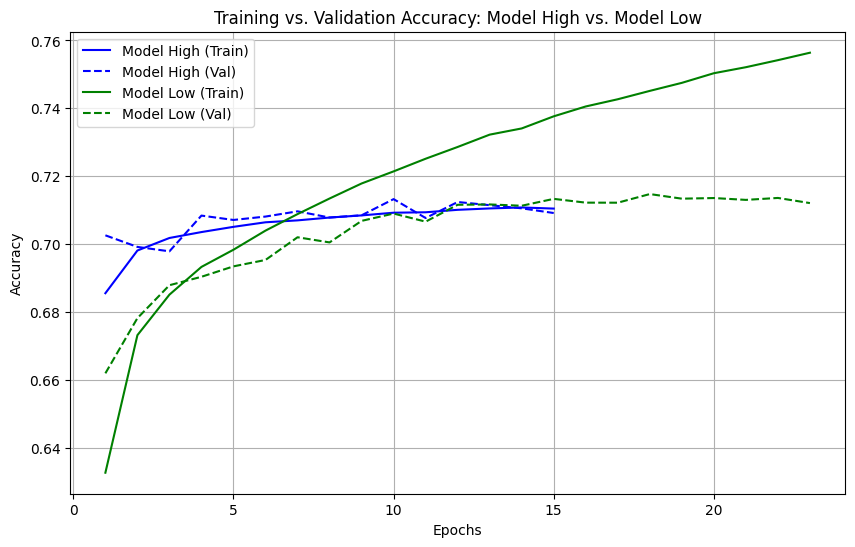

In [27]:
plt.figure(figsize=(10, 6))

# Model High
epochs_high = range(1, len(history_high.history['accuracy']) + 1)
plt.plot(epochs_high, history_high.history['accuracy'], label='Model High (Train)', color='blue')
plt.plot(epochs_high, history_high.history['val_accuracy'], label='Model High (Val)', color='blue', linestyle='--')

# Model Low
epochs_low = range(1, len(history_low.history['accuracy']) + 1)
plt.plot(epochs_low, history_low.history['accuracy'], label='Model Low (Train)', color='green')
plt.plot(epochs_low, history_low.history['val_accuracy'], label='Model Low (Val)', color='green', linestyle='--')

plt.title('Training vs. Validation Accuracy: Model High vs. Model Low')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

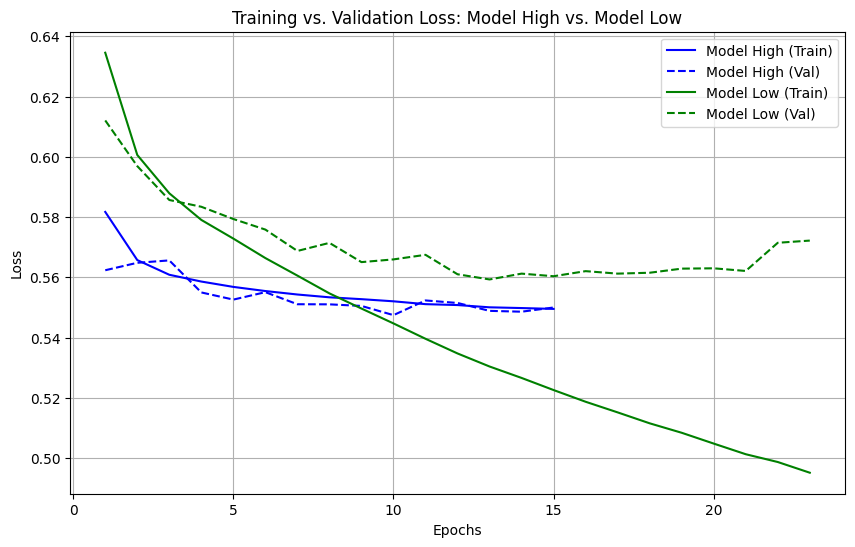

In [28]:
plt.figure(figsize=(10, 6))

# Model High
epochs_high = range(1, len(history_high.history['loss']) + 1)
plt.plot(epochs_high, history_high.history['loss'], label='Model High (Train)', color='blue')
plt.plot(epochs_high, history_high.history['val_loss'], label='Model High (Val)', color='blue', linestyle='--')

# Model Low
epochs_low = range(1, len(history_low.history['loss']) + 1)
plt.plot(epochs_low, history_low.history['loss'], label='Model Low (Train)', color='green')
plt.plot(epochs_low, history_low.history['val_loss'], label='Model Low (Val)', color='green', linestyle='--')

plt.title('Training vs. Validation Loss: Model High vs. Model Low')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot the ROC curves

In [29]:
# Generate predicted probabilities for both models
y_pred_high = model_high.predict(x_high_test)
y_pred_low = model_low.predict(x_low_test)

9375/9375 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step


In [30]:

# Compute ROC curves and AUC for both models
fpr_high, tpr_high, _ = roc_curve(y_high_test, y_pred_high)
roc_auc_high = auc(fpr_high, tpr_high)

fpr_low, tpr_low, _ = roc_curve(y_low_test, y_pred_low)
roc_auc_low = auc(fpr_low, tpr_low)

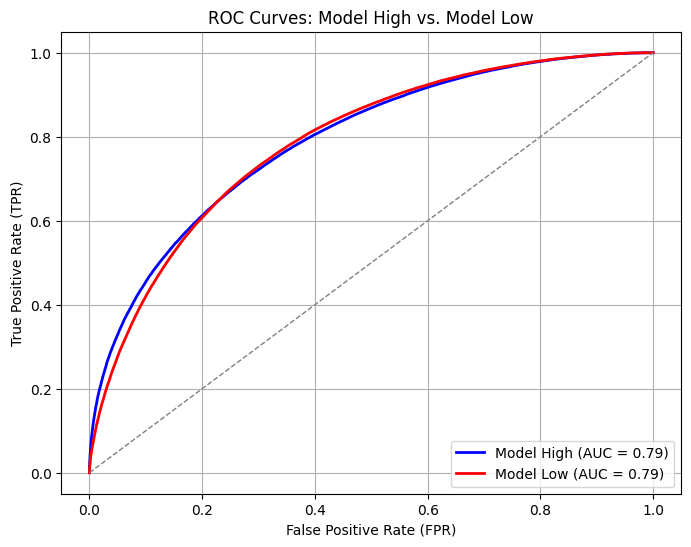

In [31]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_high, tpr_high, color='blue', lw=2,
         label=f'Model High (AUC = {roc_auc_high:.2f})')
plt.plot(fpr_low, tpr_low, color='red', lw=2,
         label=f'Model Low (AUC = {roc_auc_low:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves: Model High vs. Model Low')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Train the shallow neural network

## Build the model

In [ ]:
input_shape_high = (7,)

model_high_shallow = keras.Sequential(
    [
        keras.Input(shape=input_shape_high),
        layers.Dense(256, activation="tanh"),
        layers.Dropout(0.02),
        layers.Dense(1, activation="sigmoid"),
    ]
)

model_high_shallow.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 256)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,305 (9.00 KB)

 Trainable params: 2,305 (9.00 KB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [ ]:
batch_size = 128
epochs = 50

model_high_shallow.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    mode='max',  # Maximize validation accuracy
    verbose=1,
    restore_best_weights=True
)

history_high_shallow = model_high_shallow.fit(x_high_train, y_high_train, batch_size=batch_size, epochs=epochs,
                              validation_split=0.1, callbacks=[early_stopping])

Epoch 1/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 79s 1ms/step - accuracy: 0.6368 - loss: 0.6401 - val_accuracy: 0.6716 - val_loss: 0.6096
Epoch 2/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 76s 1ms/step - accuracy: 0.6677 - loss: 0.6070 - val_accuracy: 0.6875 - val_loss: 0.5896
Epoch 3/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 75s 1ms/step - accuracy: 0.6823 - loss: 0.5916 - val_accuracy: 0.6929 - val_loss: 0.5808
Epoch 4/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 77s 1ms/step - accuracy: 0.6880 - loss: 0.5837 - val_accuracy: 0.6955 - val_loss: 0.5743
Epoch 5/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 75s 1ms/step - accuracy: 0.6916 - loss: 0.5783 - val_accuracy: 0.6972 - val_loss: 0.5705
Epoch 6/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 80s 1ms/step - accuracy: 0.6935 - loss: 0.5752 - val_accuracy: 0.6971 - val_loss: 0.5686
Epoch 7/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 76s 1ms/step - accuracy: 0.6956 - loss: 0.5721 - val_accuracy: 0.7001 - val_loss: 0.5661
Epoch 8/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 76s 1ms/step - accuracy: 

## Evaluate the trained model

In [ ]:
score = model_high_shallow.evaluate(x_high_test, y_high_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.5566539168357849
Test accuracy: 0.7064082026481628


In [ ]:
input_shape_low = (21,)

model_low_shallow = keras.Sequential(
    [
        keras.Input(shape=input_shape_low),
        layers.Dense(256, activation="tanh"),
        layers.Dropout(0.02),
        layers.Dense(1, activation="sigmoid"),
    ]
)

model_low_shallow.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 256)            │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,889 (23.00 KB)

 Trainable params: 5,889 (23.00 KB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [ ]:
batch_size = 128
epochs = 50

model_low_shallow.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    mode='max',  # Maximize validation accuracy
    verbose=1,
    restore_best_weights=True
)

history_low_shallow=model_low_shallow.fit(x_low_train, y_low_train, batch_size=batch_size, epochs=epochs,
                          validation_split=0.1, callbacks=[early_stopping])

Epoch 1/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 77s 1ms/step - accuracy: 0.6136 - loss: 0.6497 - val_accuracy: 0.6607 - val_loss: 0.6130
Epoch 2/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 77s 1ms/step - accuracy: 0.6583 - loss: 0.6153 - val_accuracy: 0.6686 - val_loss: 0.6056
Epoch 3/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 80s 1ms/step - accuracy: 0.6671 - loss: 0.6070 - val_accuracy: 0.6750 - val_loss: 0.5991
Epoch 4/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 78s 1ms/step - accuracy: 0.6714 - loss: 0.6025 - val_accuracy: 0.6784 - val_loss: 0.5962
Epoch 5/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 74s 1ms/step - accuracy: 0.6740 - loss: 0.6000 - val_accuracy: 0.6814 - val_loss: 0.5929
Epoch 6/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 72s 1ms/step - accuracy: 0.6763 - loss: 0.5979 - val_accuracy: 0.6836 - val_loss: 0.5906
Epoch 7/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 73s 1ms/step - accuracy: 0.6772 - loss: 0.5969 - val_accuracy: 0.6841 - val_loss: 0.5906
Epoch 8/50
54141/54141 ━━━━━━━━━━━━━━━━━━━━ 74s 1ms/step - accuracy: 

## Evaluate the trained model

In [ ]:
score = model_low_shallow.evaluate(x_low_test, y_low_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.584158182144165
Test accuracy: 0.6898884773254395


# Plot the accuracy and loss

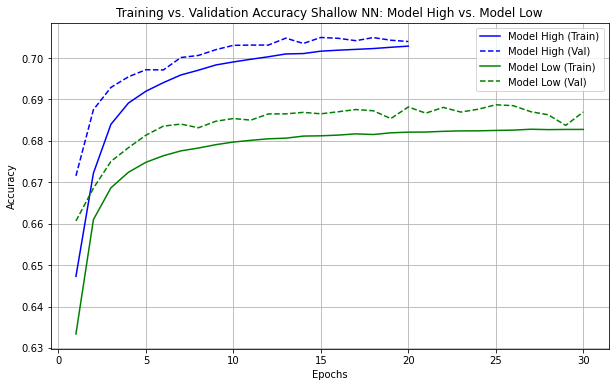

In [ ]:
plt.figure(figsize=(10, 6))

# Model High
epochs_high = range(1, len(history_high_shallow.history['accuracy']) + 1)
plt.plot(epochs_high, history_high_shallow.history['accuracy'], label='Model High (Train)', color='blue')
plt.plot(epochs_high, history_high_shallow.history['val_accuracy'], label='Model High (Val)', color='blue', linestyle='--')

# Model Low
epochs_low = range(1, len(history_low_shallow.history['accuracy']) + 1)
plt.plot(epochs_low, history_low_shallow.history['accuracy'], label='Model Low (Train)', color='green')
plt.plot(epochs_low, history_low_shallow.history['val_accuracy'], label='Model Low (Val)', color='green', linestyle='--')

plt.title('Training vs. Validation Accuracy Shallow NN: Model High vs. Model Low')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

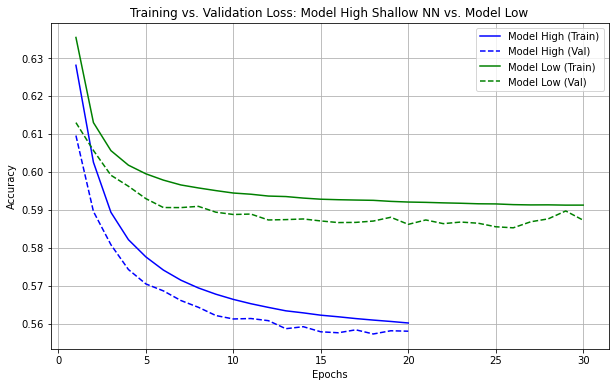

In [ ]:
plt.figure(figsize=(10, 6))

# Model High
epochs_high = range(1, len(history_high_shallow.history['loss']) + 1)
plt.plot(epochs_high, history_high_shallow.history['loss'], label='Model High (Train)', color='blue')
plt.plot(epochs_high, history_high_shallow.history['val_loss'], label='Model High (Val)', color='blue', linestyle='--')

# Model Low
epochs_low = range(1, len(history_low_shallow.history['loss']) + 1)
plt.plot(epochs_low, history_low_shallow.history['loss'], label='Model Low (Train)', color='green')
plt.plot(epochs_low, history_low_shallow.history['val_loss'], label='Model Low (Val)', color='green', linestyle='--')

plt.title('Training vs. Validation Loss: Model High Shallow NN vs. Model Low')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot the ROC curves

In [ ]:
# Generate predicted probabilities for both models
y_pred_high = model_high_shallow.predict(x_high_test)
y_pred_low = model_low_shallow.predict(x_low_test)

103125/103125 ━━━━━━━━━━━━━━━━━━━━ 112s 1ms/step
 21833/103125 ━━━━━━━━━━━━━━━━━━━━ 1:27 1ms/step

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:

# Compute ROC curves and AUC for both models
fpr_high, tpr_high, _ = roc_curve(y_high_test, y_pred_high)
roc_auc_high = auc(fpr_high, tpr_high)

fpr_low, tpr_low, _ = roc_curve(y_low_test, y_pred_low)
roc_auc_low = auc(fpr_low, tpr_low)

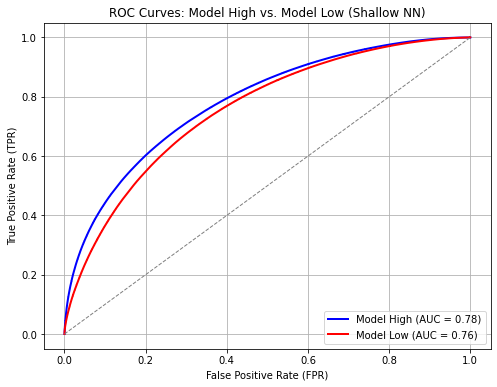

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_high, tpr_high, color='blue', lw=2,
         label=f'Model High (AUC = {roc_auc_high:.2f})')
plt.plot(fpr_low, tpr_low, color='red', lw=2,
         label=f'Model Low (AUC = {roc_auc_low:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves: Model High vs. Model Low (Shallow NN)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()